In [2]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
import six
from sklearn.metrics import roc_curve, roc_auc_score
import datetime
%matplotlib inline

In [5]:
comData = np.load("../inData/comData.npy")
comClass = np.load("../inData/comClass.npy")

In [6]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

comData = comData[..., np.newaxis]
comClassOH = processClassData(comClass)

In [8]:
# kfold x-validation...
k = 5
kfoldData = np.array_split(comData, k)
kfoldLabelsOH = np.array_split(comClassOH, k)
kfoldLabels = np.array_split(comClass, k)
print(kfoldData[0].shape)

(80, 2000, 19, 17, 1)


# Neural Network

In [9]:
spec = []
sens = []
roc = []

In [ ]:
subsamp = 20
winWidth = 8 #Must be a factor of data length (2000) and even.
steps = (2*(2000/subsamp)/winWidth)-1
if (2000/subsamp)%2 != 1:
    steps -= 1
    
for i in np.arange(0,k,1):
    roc.append([])
    for j in np.arange(0,steps,1):
        sess = tf.InteractiveSession()
        tf.reset_default_graph()
        tflearn.initializations.normal()

        # Input layer:
        net = tflearn.layers.core.input_data(shape=[None, winWidth, 19, 17, 1])

        # First layer:
        net = tflearn.layers.conv.conv_3d(net, 8, [5,5,5],  activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

        # Second layer:
        net = tflearn.layers.conv.conv_3d(net, 16, [5,5,5], activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

        # Fully connected layer
        net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
        #net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

        # Dropout layer:
        net = tflearn.layers.core.dropout(net, keep_prob=0.5)

        # Output layer:
        net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

        net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')

        model = tflearn.DNN(net, tensorboard_verbose=0)

        dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 2000, 19, 17, 1])
        dummyData = dummyData[:,::subsamp]
        dummyData = dummyData[:,0 + j*winWidth/2: winWidth + j*winWidth/2]
        print(dummyData[0,:].shape)
        dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
        model.fit(dummyData, dummyLabels, batch_size=8, n_epoch=60, show_metric=True)

        illTest = []
        healthTest = []
        for index, item in enumerate(kfoldLabels[i]):
            if item == 1:
                illTest.append(kfoldData[i][index])
            if item == 0:
                healthTest.append(kfoldData[i][index])

        healthLabel = np.tile([1,0], (len(healthTest), 1))
        illLabel = np.tile([0,1], (len(illTest), 1))
        
        sens.append(model.evaluate(np.array(healthTest)[:,::subsamp][:,0 + j*winWidth/2: winWidth + j*winWidth/2], healthLabel))
        spec.append(model.evaluate(np.array(illTest)[:,::subsamp][:,0 + j*winWidth/2: winWidth + j*winWidth/2], illLabel))

        # Get roc curve data
        predicted = np.array(model.predict(np.array(kfoldData[i])[:,::subsamp][:,0 + j*winWidth/2: winWidth + j*winWidth/2]))
        auc = roc_auc_score(kfoldLabels[i], predicted[:,1])
        roc[i].append(auc)

Training Step: 2399  | total loss: 0.13103 | time: 0.425s
| Adam | epoch: 060 | loss: 0.13103 - acc: 0.9586 -- iter: 312/320
Training Step: 2400  | total loss: 0.13751 | time: 0.437s
| Adam | epoch: 060 | loss: 0.13751 - acc: 0.9502 -- iter: 320/320
--


In [ ]:
#model.save("./outData/models/3d_conv8-16-50.tflearn")
#model.load("./outData/models/3d_conv.tflearn")

Specificity: [[0.80281692743301392], [0.91803276538848877], [0.796875]] 
Avg: 0.839241564274 
Sensitivity: [[0.8571428656578064], [0.83333331346511841], [0.82608693838119507]] 
Avg: 0.838854372501


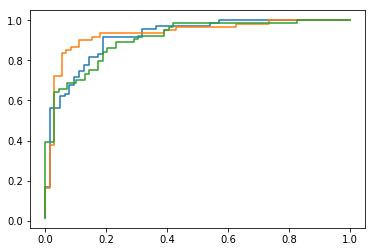

In [7]:
print("Specificity:", spec, "\nSensitivity:", sens)
for i in np.arange(0,k,1):
    for j in np.arange(0,8,1):
        plt.plot(5 + j*5, roc[i*8 + j], "x")